# Restaraunts Rating prediction

Представьте, что вы работаете DS в компании TripAdvisor. Одна из проблем компании — это нечестные рестораны, которые накручивают себе рейтинг. Одним из способов нахождения таких ресторанов является построение модели, которая предсказывает рейтинг ресторана. Если предсказания модели сильно отличаются от фактического результата, то, возможно, ресторан играет нечестно, и его стоит проверить.

<img src="https://raw.githubusercontent.com/Deus99/skillfactory_rds/master/module_3/rest.jpg"> 

# Библиотеки используемые в анализе

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
import requests
import datetime as dt
import sklearn
import stanfordnlp
import string

from time import sleep
from math import sqrt
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics # инструменты для оценки точности модели

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 4)
%matplotlib inline
RANDOM_SEED = 42

# Используемые функции

### Классы

In [3]:
class TripAdvisorParser:
    """Парсер для поиска пропущенных данных с сайта Tripadvisor.com
    при создании класса передаем часть ссылки из столбца url_ta
    после методов get_html(), prices_finder(), cuisine_finder()
    можем получить значения цен и кухни для ДФ
    price_range  - .price_range
    cuisine_style - .cuisines - (прим. в виде строки)
    """
    
    def __init__(self, url):
        self.url = 'http://www.tripadvisor.com' + url
        self.html = self.get_html()
        self.cuisines = ''
        self.price_range = ''
        
    def get_html(self):
        try:
            result = requests.get(self.url)
            result.raise_for_status()
            return result.text
        except(requests.RequestException, ValueError):
            print('Server error')
            return False
    
    def prices_finder(self):
        pr = self.html.find(r'price_level')
        if pr>0:
            self.price_range = self.html[pr:pr+25].split(":")[1].split(',')[0].replace('"','')
    
    def cuisine_finder(self):
        cuisine_text = re.compile('cuisine\":\[(.*?)\]')
        cuisine_name = re.findall(cuisine_text, self.html)
        if len(cuisine_name)>0:
            cuisine_name_list = re.compile('\"name\":\"[A-Za-z]*\s?\w*\"')
            cuisines_raw = re.findall(cuisine_name_list, cuisine_name[0])
            for cui in cuisines_raw:
                if len(self.cuisines)>3:
                    self.cuisines = self.cuisines + ', '
                self.cuisines = self.cuisines + cui.split(':')[1].replace('"','')


In [4]:
class DataPrep:
    """
    Подготовка данных для прогноза. Создает из датафрейма с текстовыми значениями
    кодированные (типа get_dummies), заполняет пропуски, удаляет лишние столбцы. 
    """
    
    def __init__(self, df):
        self.data = df.copy()
        #self.columns = columns
        self.data['res_id'] = self.data['res_id'] + '_' + self.data['city']
        self.data = self.data.set_index('res_id')
        self.MAX_WORDS = 5
    
    def fill_na(self):
        self.data['numbs_reviews'].fillna(0, inplace = True)
    
    def city_dums(self):
        self.data = pd.get_dummies(self.data, columns =['city'])
    
    def cuis_dums(self):
        self.data['cuisine_style'] = self.data['cuisine_style'].str.split(', ')
        self.allcous = self.data.explode('cuisine_style').dropna().groupby(
            'cuisine_style')['rating'].agg(['std', 'count']).query(
            'std < 0.5 & std > 0')['count'].nlargest(self.MAX_WORDS).reset_index()
        self.allcous_list = self.allcous['cuisine_style'].to_list()
        self.allcius_set = set(self.allcous_list)
        self.data.loc[~self.data.cuisine_style.isna(), 'cuisine_style'] = self.data.loc[
            ~self.data.cuisine_style.isna(), 'cuisine_style'].apply(
            lambda x: set(x)&self.allcius_set).self.data.loc[~self.data.cuisine_style.isna(
        ), 'cuisine_style'] = self.data.loc[~self.data.cuisine_style.isna(
        ), 'cuisine_style'].apply(lambda x: list(x))
        self.cuisines = self.data['cuisine_style'].explode()
        self.cuisines = pd.get_dummies(self.cuisines, 
                                       columns = ['cuisine_style'], dummy_na=True)
        self.cuisines = self.cuisines.groupby('res_id').sum()
        self.data = self.data.join(self.cuisines)
    
    def nouns_add(self):
        self.data['nouns'] = self.data['nouns'].str.split(' ')
        self.allnouns = self.data.explode('nouns').dropna(
        ).groupby('nouns')['rating'].agg(['std', 'count']).query(
            'std < 0.5 & std > 0')['count'].nlargest(self.MAX_WORDS).reset_index()
        self.allnouns_list = self.allnouns['nouns'].to_list()
        for word in self.allnouns_list:
            if len(word)<3: 
                self.allnouns_list.remove(word)
        self.allnouns_set = set(self.allnouns_list)
        self.data.loc[~self.data.nouns.isna(), 'nouns'] = self.data.loc[~self.data.nouns.isna(
        ), 'nouns'].apply(lambda x: set(x)&self.allnouns_set)
        self.data.loc[~self.data.nouns.isna(), 'nouns'] = self.data.loc[~self.data.nouns.isna(
        ), 'nouns'].apply(lambda x: list(x))
        self.nouns = self.data['nouns'].explode()
        self.nouns = pd.get_dummies(self.nouns, columns=['nouns'], dummy_na = True, prefix='noun')
        self.nouns = self.nouns.groupby('res_id').sum()
        self.data = self.data.join(self.nouns)

    def adjs_add(self):
        self.data['adjs'] = self.data['adjs'].str.split(' ')
        self.alladjs = self.data.explode('adjs').dropna().groupby('adjs')['rating'].agg(['std', 'count'])\
        .query('std < 0.5 & std > 0')['count'].nlargest(self.MAX_WORDS).reset_index()          
        self.alladjs_list = self.alladjs['adjs'].to_list()
        for word in self.alladjs_list:
            if len(word)<3: 
                self.alladjs_list.remove(word)
        self.alladjs_set = set(self.alladjs_list)
        self.data.loc[~self.data.adjs.isna(), 'adjs'] = self.data.loc[~self.data.adjs.isna(
        ), 'adjs'].apply(lambda x: set(x)&self.alladjs_set)
        self.data.loc[~self.data.adjs.isna(), 'adjs'] = self.data.loc[~self.data.adjs.isna(
        ), 'adjs'].apply(lambda x: list(x))
        self.adjs = self.data['adjs'].explode()
        self.adjs = pd.get_dummies(self.adjs, columns=['adjs'], dummy_na = True, prefix='adj')
        self.adjs = self.adjs.groupby('res_id').sum()
        self.data = self.data.join(self.adjs)
        
    def price_fill(self):
        self.data.price_range = self.data.price_range.replace(["$","$$ - $$$", "$$$$"],[1, 2, 3])
        self.data.price_range.fillna(0, inplace=True)
    
    def drops(self):
        self.data.drop(['id_ta', 'reviews', 'url_ta', 'words', 'date_prev', 'date_last',
                        'cuisine_style', 'adjs', 'nouns'], axis =1, inplace = True)
    
    def prepare_all(self):
        self.cuis_dums()
        self.city_dums()
        self.nouns_add()
        self.adjs_add()
        self.price_fill()
        self.fill_na()
        self.drops()
        print("созданы get_dummies для городов")
        print("созданы get_dummies для видов кухни")
        print("созданы get_dummies для существительных и прилагательных")
        print("price_range приведен к числовому виду")
        print("остальные NaN заменены на 0")
        return self.data


In [5]:
class ReviewsSplit():
    """
    Класс и методы для подготовки столбца Reviews. 
    Разделение текста и даты по столбцам
    Приведение столбца даты к формату dt и расчет timedelta
    Разделение существительных и прилагательных, приведение к инфинитиву.
    Заполнение пробелов в столбце cuisine_style и price_range на основе слов.
    """
    
    def __init__(self, df, column):
        self.data = df.copy()
        self.column = self.data[column]
        self.cuisines = []
        self.column = self.column.fillna('no')
        self.column = self.column.apply(lambda x: x.lower())
        word = re.compile('[a-zA-Z]+')
        self.data['words'] = self.column.apply(lambda x: re.findall(word, x))
    
    def date_split(self):
        date = re.compile('\d{2}\/\d{2}\/\d{4}')
        self.data[['date_last', 'date_prev']] = self.column.apply(
            lambda x: re.findall(date, x)).apply(lambda x: pd.Series(str(x).split(', ')))
        self.data['date_last'] = self.data['date_last'].apply(lambda x: str(x)[2:-1])
        self.data['date_prev'] = self.data['date_prev'].apply(lambda x: str(x)[1:-2])
        self.data['date_last'] = pd.to_datetime(self.data['date_last'])
        self.data['date_prev'] = pd.to_datetime(self.data['date_prev'])
        a = np.array(self.data['date_last'])
        b = np.array(self.data['date_prev'])
        c = np.array([a, b])
        c.T.sort()
        self.data['date_prev'] = c[0]
        self.data['date_last'] = c[1]
    
    def words_split(self):
        word = re.compile('[a-zA-Z]+')
        self.data['words'] = self.column.apply(lambda x: re.findall(word, x))
        self.data['words'] = self.data['words'].apply(lambda x: set(x))
    
    def cuisines_extra(self):
        self.cuisines = self.data.dropna()['cuisine_style'].str.split(', ').explode().to_list()
        self.cuisines = set(self.cuisines)
        self.data['cuisine_extra'] = self.data['words'].apply(lambda x: x&self.cuisines)
        self.data['cuisine_extra'] = self.data['cuisine_extra'].astype(str)
        self.data['cuisine_extra'] = self.data['cuisine_extra'].replace('set()', np.nan)
        self.data.loc[~self.data.cuisine_extra.isna(), 'cuisine_extra'] = self.data.loc[
            ~self.data.cuisine_extra.isna(), 'cuisine_extra'].apply(
            lambda x: str(x)[1:-1].replace("'", ""))
        self.data['cuisine_style'] = self.data['cuisine_style'].fillna(self.data['cuisine_extra'])
        return self.cuisines
    
    def split_and_explode(self):
        self.date_split()
        self.words_split()
        self.cuisines_extra()
        return self.data
    

### Используемые функции

In [6]:
def fill_ta(row):
    """Парсинга сайта TripAdvisor.com,
    для поиска значений для кухни и цен.
    """
    url_ta = row['url_ta']
    data = TripAdvisorParser(url_ta)
    data.get_html()
    data.prices_finder()
    data.cuisine_finder()
    #print(data.cuisines)
    #print(data.price_range)
    #if row['cuisine_style'].isnull().values.any():
    if data.cuisines != '':
        row['cuisine_style'] = data.cuisines
    #if row['price_range'].isnull().values.any():
    if data.price_range != '':
        row['price_range'] = data.price_range
    sleep(0.25)
    return row

def parsed_to_file(df, filename):
    """
    Загрузка файла с заполнеными пропусками с сайта TripAdvisor.com
    или запуск парсинга. 
    Прим. Процесс парсинга занимает продолжительное время. 
    """
    filename = filename + '_parsed.csv'
    try:
        df = pd.read_csv(filename)
    except (FileNotFoundError) :
        print("Start parsing...")        
        rs_filter = df.cuisine_style.isna() | df.price_range.isna()
        df.loc[rs_filter] = df.loc[rs_filter].apply(fill_ta, axis=1)
        df.to_csv(filename, na_rep="", index = False)
    return df

def words_select(row):
    """
    Разбивает слова из отзыва на существительные и прилагательные.
    Из прилагательных убирает название стилей кухни (напр. russian)
    """
    nlp = stanfordnlp.Pipeline(use_gpu = True)
    doc = nlp(row.words.translate(str.maketrans('', '', string.punctuation)))
    adjs = ''
    nouns = ''
    if len(doc.sentences) > 0:
        for word in doc.sentences[0].words:
            if (word.upos == 'ADJ') and (word.lemma not in cuisines):
                adjs = adjs + ' ' + word.lemma
            if (word.upos == 'NOUN') and (word.lemma not in cuisines):
                nouns = nouns + ' ' + word.lemma  
    row['adjs']=str(adjs)
    row['nouns']=str(nouns)
    return row

def data_add(df, column):
    """
    Добавляет столбец из таблицы excel, которые загружены с сайта eurostat
    название столбцы должно совпадать с названием файла. 
    Edinburg необходимо добавить вручную, Шотландии нет =(
    """
    column = column
    filename = str(column) +".xls"
    
    # написание городов отличается
    cities_names={
        'Milano': 'Milan',
        'München': 'Munich',
        'Porto': 'Oporto',
        'Roma': 'Rome',
        'Wien': 'Vienna',
        'Warszawa': 'Warsaw',
        'Zürich': 'Zurich',
        'Praha': 'Prague',
        'Greater Amsterdam': 'Amsterdam',
        'Athina': 'Athens',
        'Helsinki / Helsingfors': 'Helsinki',
        'Genève': 'Geneva',
        'Lisboa': 'Lisbon',
        'Kraków': 'Krakow',
        'København': 'Copenhagen'}
    
    data = pd.read_excel(filename, skiprows=8)
    data.rename(columns = {'CITIES/TIME': 'city'}, inplace=True)
    data['city'] = data['city'].str.replace(' \(greater city\)','')
    data.drop_duplicates(subset=['city'], inplace = True)

    # За основу берется 2018 год, пропуски заполняются из других столбцов с годами
    years = data.columns
    years = years.drop(['city', '2018']).to_list()
    years.reverse()

    for year in years:
        data['2018'].fillna(data[year], inplace=True)

    data.replace({'city': cities_names}, inplace=True)
    data.drop(['2010','2011', '2012', '2013', '2014', '2015', 
                 '2016', '2017', '2019'], axis=1, inplace=True)
    df = df.merge(data, how="left")
    df.rename(columns={'2018': column}, inplace=True)
    df[column] = df[column].astype(int)
    return df

def iqr_test(column, lim_a, lim_b):
    """
    Функция определения медианы, квантилей 25%/75% и 
    границы выбросов для данного сталбцы 
    lim_a lim_b - пределы для построенния гистограммы
    """
    median = ms[column].median()
    IQR = ms[column].quantile(0.75) - ms[column].quantile(0.25)
    perc25 = ms[column].quantile(0.25)
    perc75 = ms[column].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), 
          '75-й перцентиль: {},'.format(perc75), 
          "IQR: {}, ".format(IQR),
          "Границы выбросов: [{f}, {l}]."
          .format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    ms[column].loc[ms[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].\
    hist(bins=8, range=(lim_a, lim_b), label='IQR')

def to_mill(value):
    """
    Преобразует значения в миллионы и округляет
    """
    value = round(value/10**6, 2)
    return value

def fill_dates(dataframe):
    """
    Заполняет последний отзыв - предыдущим, если отзыв один
    остальные заполняет средним
    создает столбец date_last_delta - время отзыва относительно самого старого в ДФ.
    """
    dataframe.date_last = dataframe.date_last.fillna(dataframe.date_prev)
    dl_mean = dataframe['date_last'].mean()
    dt_mean = dataframe['date_prev'].mean()
    dataframe['date_last'] = dataframe['date_last'].fillna(dl_mean)
    dataframe['date_prev'] = dataframe['date_prev'].fillna(dt_mean)
    dataframe['timedelta'] = dataframe['date_last'] - dataframe['date_prev']
    data_max = dataframe['date_last'].max()
    dataframe['date_last_delta'] = data_max - dataframe['date_last']
    dataframe['date_last_delta'].dt.days
    dataframe['date_last_delta'] = dataframe['date_last_delta'].apply(lambda x: x.days)
    dataframe['timedelta'] = dataframe['timedelta'].apply(lambda x: x.days)
    return dataframe

native_cousine = {'Amsterdam': 'dutch', 'Athens': 'greek', 'Barcelona': 'spanish', 
                  'Berlin': 'german', 'Brussels': 'belgian', 'Budapest': 'hungarian', 
                  'Copenhagen': 'danish', 'Dublin': 'irish', 'Edinburg': 'scottish', 
                  'Geneva': 'swiss', 'Hamburg': 'german', 'Krakow': 'polish', 
                  'Lisnon': 'portuguese', 'Ljubljana': 'slovenian', 'London': 'british',
                  'Lyon': 'french', 'Madrid': 'spanish', 'Milan': 'italian', 
                  'Munich': 'german', 'Oporto': 'portuguese', 'Oslo': 'norwegian',
                 'Paris': 'french', 'Prague': 'czech', 'Rome': 'italian',
                 'Stockholm': 'swedish', 'Vienna': 'austrian', 'Warsaw': 'polish',
                 'Zurich': 'swiss'}

def native_fill(row):
    """
    создает столбец для домашней кухни данной страны
    """
    if str(row['native']) in str(row['cuisine_style']):
        row['native_yn'] = 1
    else:
        row['native_yn'] = 0
    return row

## Функции для визуализации

In [7]:
def viz_beforeafter(df, params):
    """
    Сравнивает столбцы ДО/ПОСЛЕ в датафрейме, строит диаграмму
    df - датафрейм
    params - словарь параметров
    {
    'labels': список значение, можно заменить df.index(), 
    'col_bf': столбец с предыдущими значениями 
    'col_af': столбец с последними значениями
    'ylab': подпись по оси Y
    'title': название
    }
    """
    
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = (9,6)
    labels = params['labels']
    ta_before = df[params['col_bf']].to_list()
    ta_after = df[params['col_af']].to_list()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, ta_before, width, label='before')
    rects2 = ax.bar(x + width/2, ta_after, width, label='after')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(params['ylab'])
    ax.set_title(params['title'])
    ax.set_ylim(0, 16000)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

    
def viz_gp(df, col_gp, col_arg, title, mill=False, rn=False):
    """
    Группирует и показывает среднее значение
    Преобразует в миллионы и округляет (по умолчанию - нет)
    df - датафрейм, col_gp - столбец для группировки, col_arg - столбец с аргументами
    mill - преобразовать в миллионы (False по умолчанию), 
    rn - округлить до 2х знаков (False по умолчанию)
    """
    values_grp = df.groupby(col_gp)[col_arg].agg('mean').sort_values(ascending=True)
    
    if mill: values_grp = to_mill(values_grp)
    if rn: values_grp = round(values_grp, 2)
        
    fig, ax = plt.subplots()
    plt.figure 
    plt.rcParams['figure.figsize'] = (12,12)
    
    ax = values_grp.plot(kind='barh', title = title)
    ax.set_xlim(0, values_grp.max()*1.15)
    
    for i, v in enumerate(values_grp):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()   
    

def viz_gph(df, col_gp, col_arg, title, sort_by_index = False, mill=False, rn=False, acc=2):
    """
    Группирует и показывает среднее значение, вертикальные столбцы
    Преобразует в миллионы и округляет (по умолчанию - нет)
    df - датафрейм, col_gp - столбец для группировки, col_arg - столбец с аргументами
    mill - преобразовать в миллионы (False по умолчанию), 
    rn - округлить до 2х знаков (False по умолчанию)
    """
    values_grp = df.groupby(col_gp)[col_arg].agg('mean').sort_values(ascending=True)
    
    if sort_by_index: values_grp = values_grp.sort_index()
    if mill: values_grp = to_mill(values_grp)
    if rn: values_grp = round(values_grp, acc)
    
    fig, ax = plt.subplots()
    plt.figure 
    plt.rcParams['figure.figsize'] = (12,12)
    ax = values_grp.plot(kind='bar', title = title)
    ax.set_ylim(0, values_grp.max()*1.15)
    
    for i, v in enumerate(values_grp):
        plt.text(i, v+(values_grp.max()/100), ""+str(v), ha='center')
    
    plt.show()   

    

def viz_counter_barh(df, column, title, max_values=0):
    """
    Визуализация количества значений в ДФ, Value_counts, 
    горизонтальные столбцы
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения, 0 - все
    """
    if max_values >0:
        col_values = df[column].value_counts().nlargest(max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12,12)
    plt.figure 
    ax = col_values.plot(kind='barh', title = title)
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()

def viz_counter_bar(df, column, title, max_values=0, sort_by_index=False, dollars=False):
    """
    Визуализация количества значений в ДФ, Value_counts, 
    горизонтальные столбцы
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения, 0 - все
    sort_by_index - сортирует по индексам, а не значениям
    dollars - отображает подписи с $$ для price_range
    """
    if max_values >0:
        col_values = df[column].value_counts().nlargest(max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    if sort_by_index: col_values = col_values.sort_index()
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (10,10)
    plt.figure 
    ax = col_values.plot(kind='bar', title = title)
    
    if dollars: ax.set_xticklabels(('\$', '\$\$ - \$\$\$', '\$\$\$\$'), rotation='horizontal')
    
    ax.set_ylim(0, col_values.max()*1.15)
    for i, v in enumerate(col_values):
        plt.text(i, v+(col_values.max()/100), ""+str(v), ha='center')
    
    plt.show()
    
    

# Загрузка данных

In [8]:
df = pd.read_csv("main_task.xls")
df_test = pd.read_csv("kaggle_task.csv")
df_test.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
4206,id_4206,Munich,['Turkish'],1511.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187309-d4047682-Reviews-Al...,d4047682
7856,id_7856,Berlin,NaN,4047.0,NaN,4.0,"[['Gets better and better!', 'Container coffee...",/Restaurant_Review-g187323-d8430358-Reviews-Ca...,d8430358
3577,id_3577,Rome,['American'],3441.0,NaN,37.0,"[[], []]",/Restaurant_Review-g187791-d8751999-Reviews-Vt...,d8751999


In [9]:
#Переименуем столбцы
df.columns = ['res_id', 'city', 'cuisine_style', 'ranking', 'rating', 
              'price_range', 'numbs_reviews', 'reviews', 'url_ta', 'id_ta']
df_test.columns = ['res_id', 'city', 'cuisine_style', 'ranking', 
              'price_range', 'numbs_reviews', 'reviews', 'url_ta', 'id_ta']

## Оценка уникальных значений и типов переменных в датафрейме

In [10]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
res_id,40000,11909,id_871,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,40000,31,London,5757,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cuisine_style,30717,9007,['Italian'],1032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ranking,4e+04,NaN,NaN,NaN,3676,3709,1,973,2285,5260,1.644e+04
rating,4e+04,NaN,NaN,NaN,3.993,0.6684,1,3.5,4,4.5,5
price_range,26114,3,$$ - $$$,18412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numbs_reviews,3.746e+04,NaN,NaN,NaN,124.8,295.7,2,9,33,115,9660
reviews,40000,33516,"[[], []]",6471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url_ta,40000,39980,/Restaurant_Review-g187514-d7337366-Reviews-La...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id_ta,40000,39980,d793170,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего в датафрейме 40000 записей, пропуски в столбцах **Cuisine Style**, **Price Range**, **Number of Reviews**.   
Остальные столбцы **Restaraunt_id, City, Ranking, Rating, Reviews, URL_TA, ID_TA** - без пропусков.   
Рассмотрим столбцы подробней

Три столбца являются *количественными* переменными:  
**ranking** - место, которое занимает данный ресторан среди всех ресторанов своего города;  
**rating** - рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
**numbs_reviews** - количество отзывов о ресторане;  

Категориальные (оценочные), 4 столбца:  
**city** - город, в котором находится ресторан, всего 31 город, самый популярный - **London**   
**couisine_style** - кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане. Самая распространенная - итальянская (*italian*)    
**price_range** - диапазон цен в ресторане:  \\$  - низкая ценовая категория ,  \\$\\$ - \\$\\$\\$  - средняя ценовая категория, \\$\\$\\$\\$  - рестораны высокой кухни    
**numbs_eviews** - количество отзывов о ресторане;

Другие данные:  
**res_id** — идентификационный номер ресторана / сети ресторанов;  
**reviews** — данные о двух отзывах, которые отображаются на сайте ресторана;  
**url_ta** — URL страницы ресторана на TripAdvisor;

## Исправление пропусков в данных

### Количество пропусков в колонках

In [11]:
display(df.isnull().sum())
ta_before = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'ta_before'}).query('ta_before>0')

res_id               0
city                 0
cuisine_style     9283
ranking              0
rating               0
price_range      13886
numbs_reviews     2543
reviews              0
url_ta               0
id_ta                0
dtype: int64

Больше всего пропусков в графе с ценами (почти треть), более 9000 значений в стлях кухни.  

### Заполнение пропусков с сайта TripAdvisor.com

В каждой строке датафрейма есть ссылка на ресторан, которую можно использовать для поиска нужных значений. Но стоит учесть, что данные могут устареть (например ресторан закрылся) или данных(оценок) еще недостаточно для данных о кухне или цене. 

In [12]:
# Загрузка пропущенных значений с сайта TripAdvisor.com
df = parsed_to_file(df, 'main_task')
df_test = parsed_to_file(df_test, 'kaggle_task')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   res_id         40000 non-null  object 
 1   city           40000 non-null  object 
 2   cuisine_style  35286 non-null  object 
 3   ranking        40000 non-null  float64
 4   rating         40000 non-null  float64
 5   price_range    32520 non-null  object 
 6   numbs_reviews  37457 non-null  float64
 7   reviews        40000 non-null  object 
 8   url_ta         40000 non-null  object 
 9   id_ta          40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [14]:
#Исправим формат в столбце с кухней
df.cuisine_style = df.cuisine_style.str.replace("'","")
df.cuisine_style = df.cuisine_style.str.replace("[","")
df.cuisine_style = df.cuisine_style.str.replace("]","")

In [15]:
df_test.cuisine_style = df_test.cuisine_style.str.replace("'","")
df_test.cuisine_style = df_test.cuisine_style.str.replace("[","")
df_test.cuisine_style = df_test.cuisine_style.str.replace("]","")

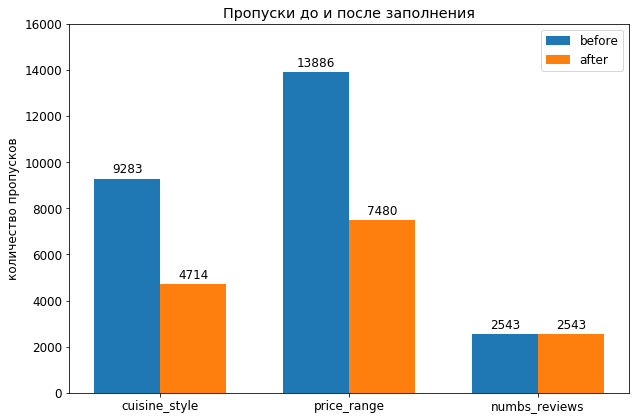

In [16]:
ta_after = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'ta_after'}).query('ta_after>0')
ta_result = ta_before.join(ta_after)

pars_nan={'labels': ta_result.index.to_list(), 'col_bf': 'ta_before', 
        'col_af': 'ta_after', 'ylab': 'количество пропусков', 
        'title': 'Пропуски до и после заполнения'}

viz_beforeafter(ta_result, pars_nan)

После парсинга сайта удалось заполнить около половины пропусков в столбцах **cuisine_style** и **price_range**. Еще часть пропусков можно заполнить если проанализировать текст отзывов, в которых упоминаются основные блюда, кухня или пищевые ограничения (вегетарианская, кошерная и др.) 

*Примечание* Заполнения пропусков средними и другими значения происходит во время подготовки датаферйма для обучения при помощи **DataPrep**

In [17]:
df.head(2)

,res_id,city,cuisine_style,ranking,rating,price_range,numbs_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"european, french, international",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,"asian, nepali",1537.0,4.0,$$ - $$$,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


# EDA - Разведывательный анализ данных

## City - города, в которых находятся рестораны

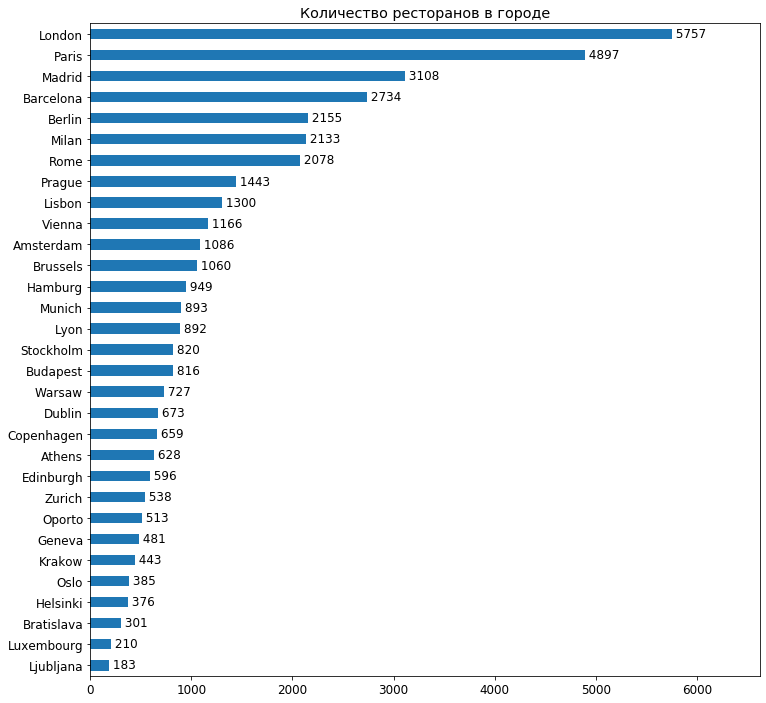

In [19]:
viz_counter_barh(df, 'city', 'Количество ресторанов в городе')

### Население и туризм

Добавив в наш датафрейм данные о населении и туризме с сайта eurostat. 

In [20]:
df = data_add(df, 'population')
df = data_add(df, 'tourism')
df_test = data_add(df_test, 'population')
df_test = data_add(df_test, 'tourism')

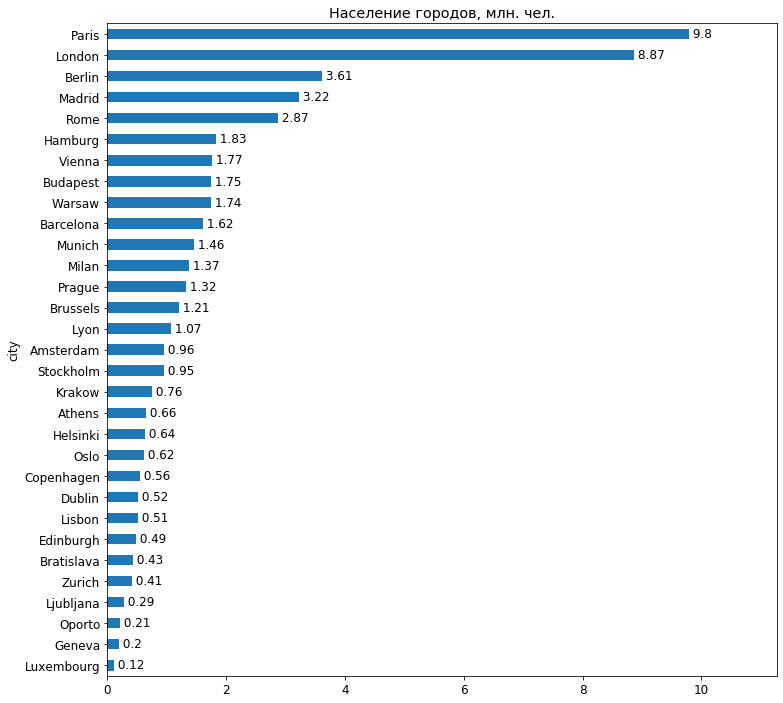

In [21]:
viz_gp(df, 'city', 'population', 'Население городов, млн. чел.', mill=True)

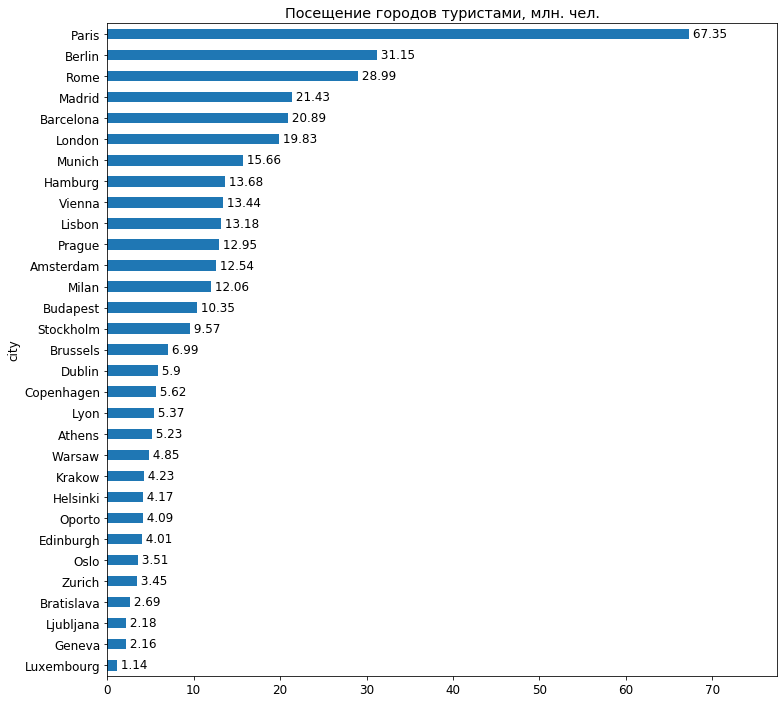

In [22]:
viz_gp(df, 'city', 'tourism', 'Посещение городов туристами, млн. чел.', mill=True)

Предсказуемая и логическая ситуация, в больших туристических городах больше всего ресторанов. 

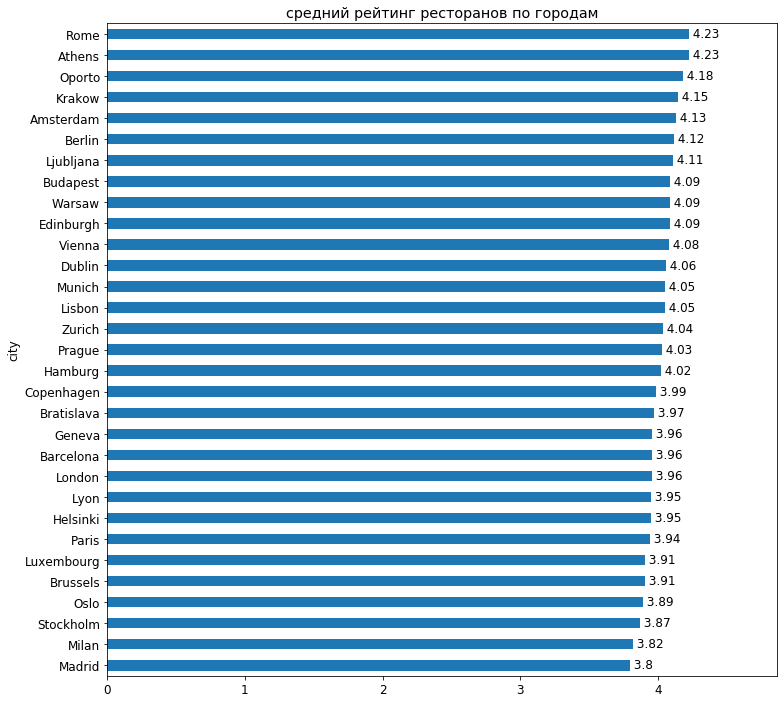

In [23]:
viz_gp(df, 'city', 'rating', 'средний рейтинг ресторанов по городам', rn=True)

По средней оценке можно выделить лидеров - Рим, Афины, Порту, Краков, Амстердам, Берлин.  
Самые низкие оценки у городов Мадрид, Милан, Стокгольм, Осло, Париж. 
Города с большим турпотоком (Париж, Барселона) оказались ниже чем менее популярные (Порту, Афины, Краков). В таких городах (с большим кол-вом туристов) очень много так называемых - "туристических ловушек". Ресторанов с завышенными ценами и посредственным обслуживанием.  

## Cuisine_style - кухни, и их особенности

Для начала псомотрим, какие кухни (или ограничения) являются самыми распространненными. Согласно фильтру на сайте **TripAdvisor** есть разделения
- на кухни: испанская, итальянская и пр.  
- на кухни по региону: европейская, азиатская и пр.
- ограничения по питания: кошерная пища, вегитарианская и пр.
- тип заведения если это не ресторан: бар, паб, вииний бар

In [24]:
cuisines = list(df['cuisine_style'].str.split(", ").explode().unique())
print("Всего представлено {} видов кухонь".format(len(cuisines)))

Всего представлено 141 видов кухонь


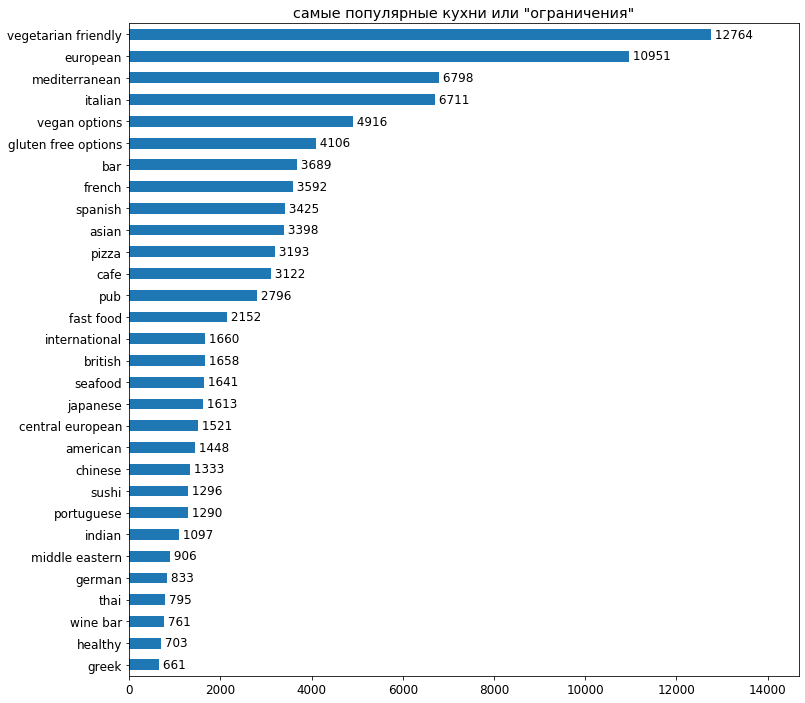

In [25]:
cuisines_top = df.cuisine_style.str.split(', ').explode().reset_index()
viz_counter_barh(cuisines_top, 'cuisine_style', 
                 'самые популярные кухни или "ограничения"', max_values=30)

В изначальном датафрейме было 125 видов стилей кухни, после заполнения их стало 141!  
Если судить по странам происхождения, то самые популярные: итальянская, французская, испанская, британская, японская, американская, китайская, португальская, индийская, немецая, тайская, греческая.   
Очень выжным являются ограничения в питании, неудивительно, что на первом месте - блюда вегетарианской кухни. Также среди популярных есть веганская кухня, блюда без глютена, здоровая пища.  
Отдельно стоит отметить, что не все заведения являются ресторанами. Также стоит отметить пабы, бары, кафе и даже винные бары, пиццерия, рестораны фастфуда.  
И последнне на что стоит обратить внимание, региональные предпочтения: европейкая кухня, среднеземноморская, азиатская и др.


In [26]:
# сделаем замены для удобства работы
df['cuisine_style'] = df['cuisine_style'].str.replace('vegetarian friendly', 'vegetarian')
df['cuisine_style'] = df['cuisine_style'].str.replace('vegan options', 'vegan')
df['cuisine_style'] = df['cuisine_style'].str.replace('gluten free options', 'gluten')

In [27]:
df_test['cuisine_style'] = df_test['cuisine_style'].str.replace('vegetarian friendly', 'vegetarian')
df_test['cuisine_style'] = df_test['cuisine_style'].str.replace('vegan options', 'vegan')
df_test['cuisine_style'] = df_test['cuisine_style'].str.replace('gluten free options', 'gluten')

## Ranking - место ресторана по рейтингу. 

В каждом городе есть своя классификация ресторанов по популярности, места начинаются с 1го. **Ranking** - показывает это место. Первые места есть в каждом городе, но в больших городах может быть по 12-15 тыс. ресторанов, а в маленьких несколько сотен. 

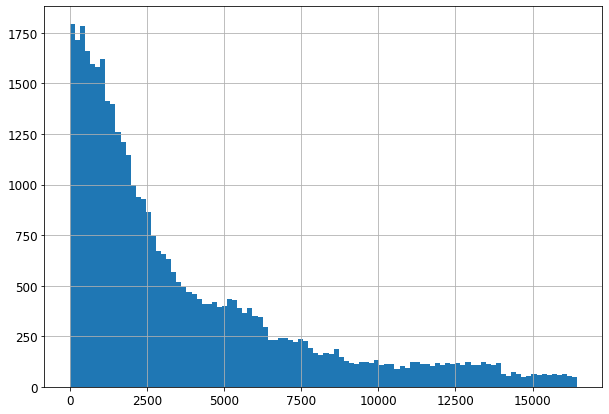

In [28]:
plt.rcParams['figure.figsize'] = (10,7)
df['ranking'].hist(bins=100)

Много ресторанов, которые не дотягивают до 2500 места в своем городе. Посмотрим как выглядит разность оценок, в зависимости от места. Для этого посмотрим распределение оценок относительно рейтинга для разных городов, например оценок от 4 до 5 и для городов Лондон и Милан.

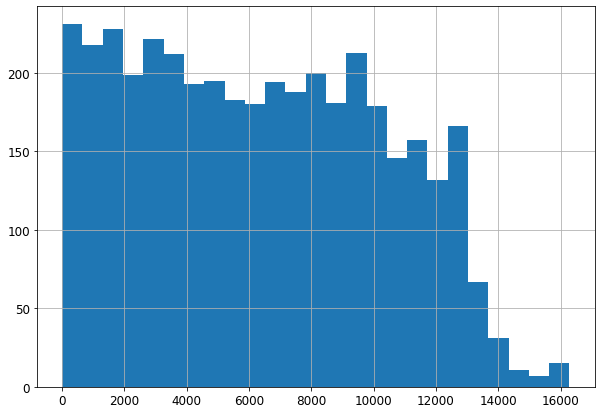

In [29]:
df.query('city=="London"')['ranking'][df['rating'].between(4, 5)].hist(bins=25)

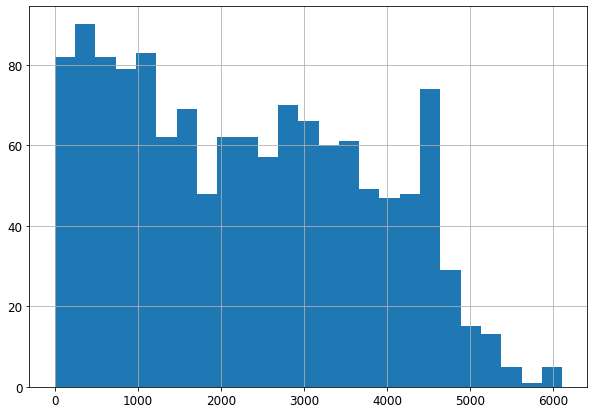

In [30]:
df.query('city=="Milan"')['ranking'][df['rating'].between(4, 5)].hist(bins=25)

Из диаграмм можно предположить, что распределение примерно одинаковое, в не зависимости от количества ресторанов (6000 и 16000). Зависимость скорее всего нелинейная. Поэтому желательно нормальзовать признак в зависимости от города, и возможно изменить зависимость (полином вместо линейной). 

## Rating - рейтинг ресторана

**Rating** - рейтинг ресторана на сайте TripAdvidor. Рейтинг рассчитывается на основе отзывов пользователей, на который влияют количество отзывов, время последнего отзыва и др. признаки.

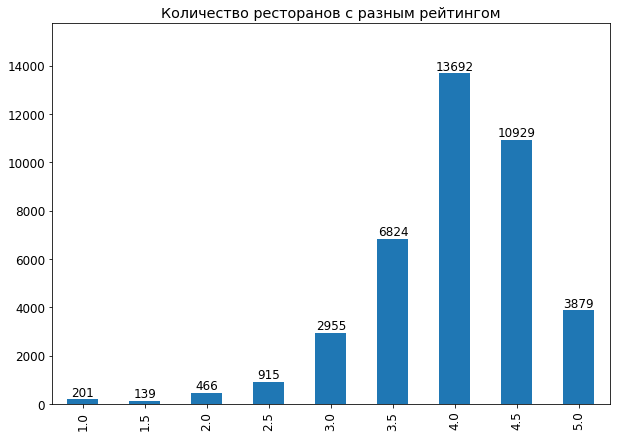

In [31]:
viz_counter_bar(df, 'rating', 'Количество ресторанов с разным рейтингом', sort_by_index=True)

Итак, больше всего у нас "хороших" оценок - 4 и 4.5. Оценки 2,5 и меньше встречаются гораздо реже. Оценка 1.0 - примерно в 0,5% случаев, а оценка 1.5 еще реже. Стоит ли их учитывать? 

## Price Range - уровень цен

Всего представлено 3 категории ресторанов по цене:
- \\$ - дешевые рестораны  
- \\$\\$ - \\$\\$\\$ - средняя ценовая категория  
- \\$\\$\\$\\$  - дорогие рестораны

Для начала посмотрим на количество.

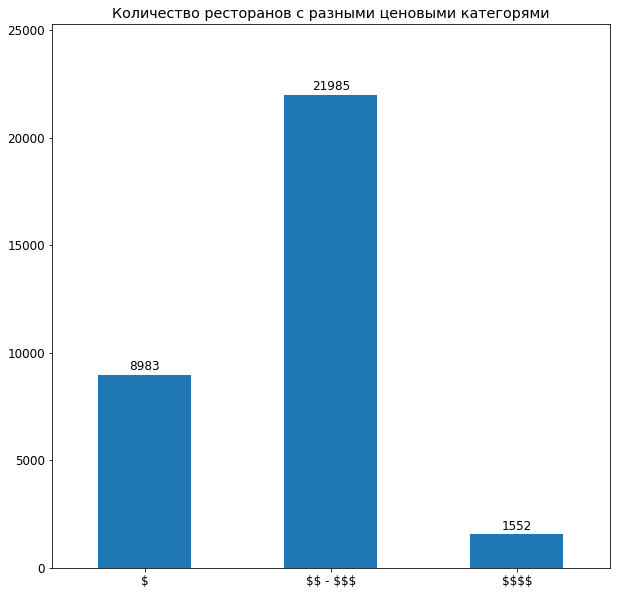

In [32]:
prices = df.price_range.replace({'$':'1', '$$ - $$$': '2', '$$$$': '3'}).reset_index()
viz_counter_bar(prices, 'price_range', 
                'Количество ресторанов с разными ценовыми категорями', 
                sort_by_index=True, dollars=True)

Больше половины ресторанов средней ценовой категории "\\$\\$-\\$\\$\\$", меньше 5\% от общего количества - дорогие рестораны.

## Number of reviews - количество отзывов

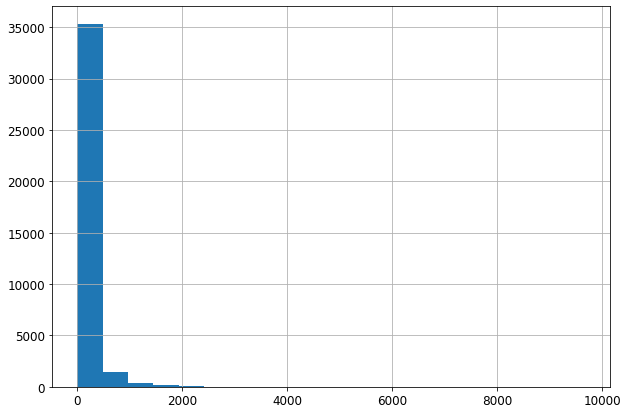

In [33]:
plt.rcParams['figure.figsize'] = (10,7)
df['numbs_reviews'].hist(bins=20)

Большинство ресторанов имеют очень мало отзывов. Минимальное - 2, максимальное - 9660, среднее около 125. 

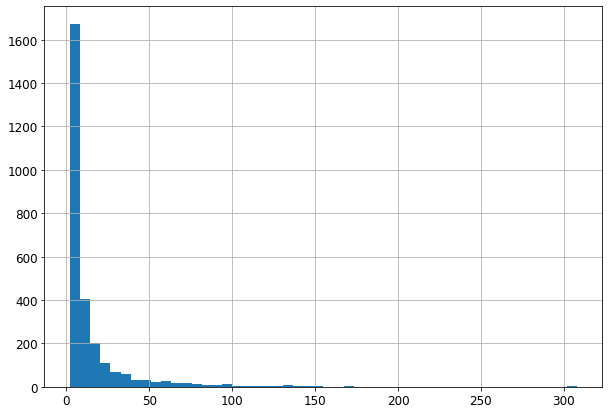

In [34]:
df[(df.rating==5) & (df.numbs_reviews < df.numbs_reviews.quantile(0.9))].numbs_reviews.hist(bins=50)

И как видно из диаграммы для того, в 90% случаев чтобы получить рейтинг - 5, не обязательно иметь тысячи отзывов, достаточно хорошо готовить и обслуживать. 

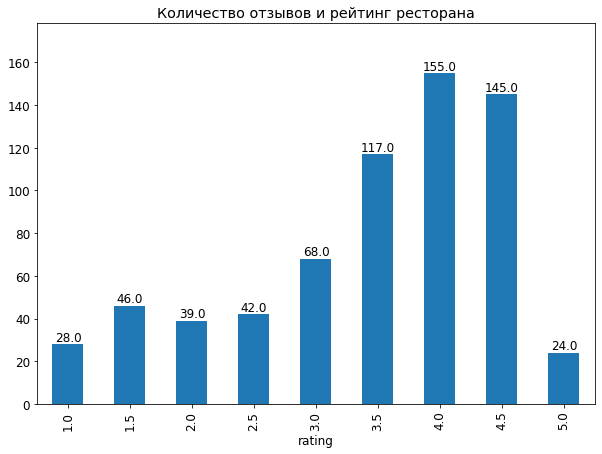

In [35]:
viz_gph(df, 'rating', 'numbs_reviews', 'Количество отзывов и рейтинг ресторана', 
        sort_by_index = True, rn=True, acc=0)

Количество отзывов влияет на итоговую оценку (*прим. об этом написано на сайте TA*). Много отзывов у хороших ресторанов с рейтингом 4 и 4,5. И как не странно мало отзывов у ресторанов с рейтингом 5.   

## Reviews - отзывы

Отзывы можно разделить по времени, на положительные/отрицательные, а также можно найти информацию о кухне, блюдах и заполнить пропуски в данных.

При помощи данной функции разобьем отзывы на даты (последний и предпоследний отзывы), слова (без дубликатов). На отзыв (положительный или отрицательный) больше влияют существительные или качественные прилагательные: хороший, плохой, вкусный и пр.
Анализом слов займемся ниже. 

In [37]:
# Разбиваем отзывы на столбцы с датами, ключевыми словами, выделяем упоминаем кухни в отзывах, немного заполняем пропуски. 
df = ReviewsSplit(df, 'reviews').split_and_explode()
df_test = ReviewsSplit(df_test, 'reviews').split_and_explode()

In [38]:
df = fill_dates(df)
df_test = fill_dates(df_test)

In [39]:
df.describe()

,ranking,rating,numbs_reviews,population,tourism,timedelta,date_last_delta
count,40000.0000,40000.0000,37457.0000,4.0000e+04,4.0000e+04,40000.0000,40000.0000
mean,3676.0285,3.9930,124.8255,3.6866e+06,2.1736e+07,122.3822,289.3069
std,3708.7496,0.6684,295.6664,3.5018e+06,1.8680e+07,193.4068,333.3994
min,1.0000,1.0000,2.0000,1.1523e+05,1.1390e+06,0.0000,0.0000
25%,973.0000,3.5000,9.0000,1.0747e+06,1.0348e+07,13.0000,91.0000
50%,2285.0000,4.0000,33.0000,1.7667e+06,1.9828e+07,76.0000,203.0000
75%,5260.0000,4.5000,115.0000,8.8665e+06,2.1434e+07,122.0000,289.0000
max,16444.0000,5.0000,9660.0000,9.8035e+06,6.7347e+07,3207.0000,5059.0000


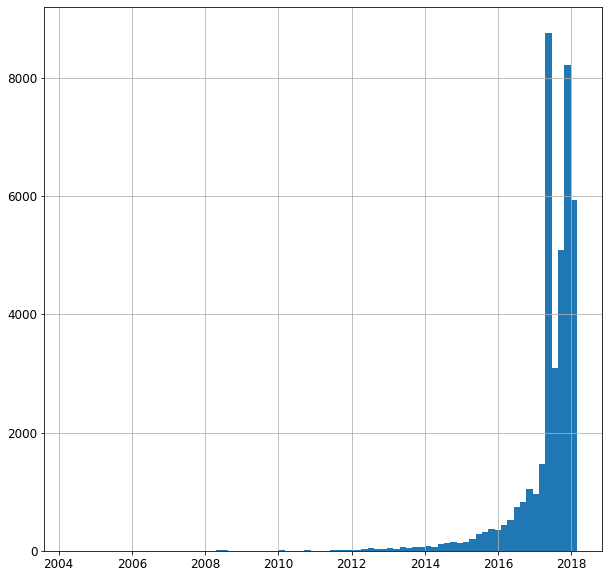

In [40]:
plt.rcParams['figure.figsize'] = (10,10)
df['date_last'].hist(bins=80)

Большинство отзывов приходится на 2017 год, самый первый из отзывов (последний) приходится на 2004 год. 

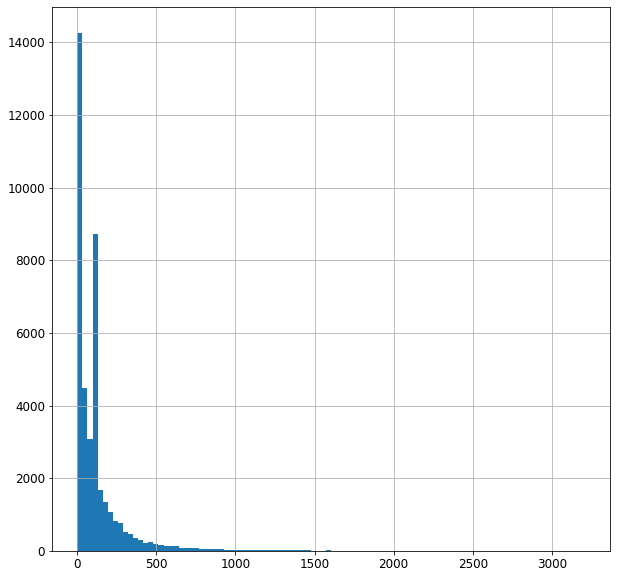

In [41]:
plt.rcParams['figure.figsize'] = (10,10)
df['timedelta'].hist(bins=100)

In [42]:
df.timedelta.describe()

count    40000.0000
mean       122.3822
std        193.4068
min          0.0000
25%         13.0000
50%         76.0000
75%        122.0000
max       3207.0000
Name: timedelta, dtype: float64

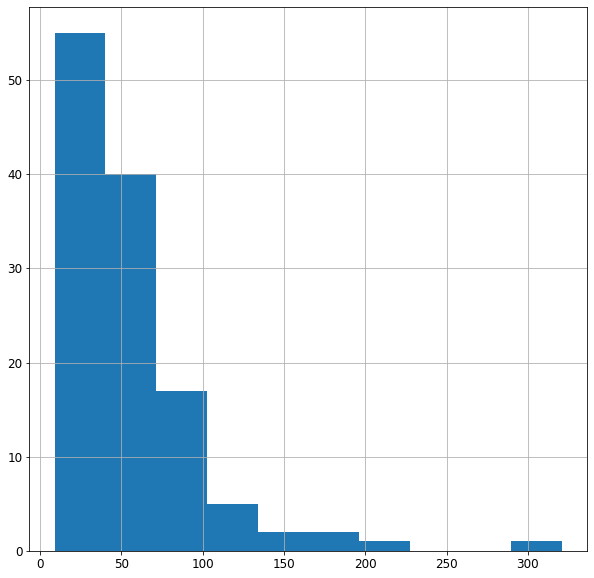

In [43]:
plt.rcParams['figure.figsize'] = (10,10)
df_td = df.groupby('timedelta')['numbs_reviews'].mean().reset_index()
df_td.groupby(df_td.index//10)['numbs_reviews'].mean().hist()

Максимальное время между отзывами - 3207 дней! но больше половины времени между отзывами укладывается в 67 дней.

## Корреляционный анализ

Вначале посмотрим столбцы датафрейма относительно друг друга и целевой переменной.

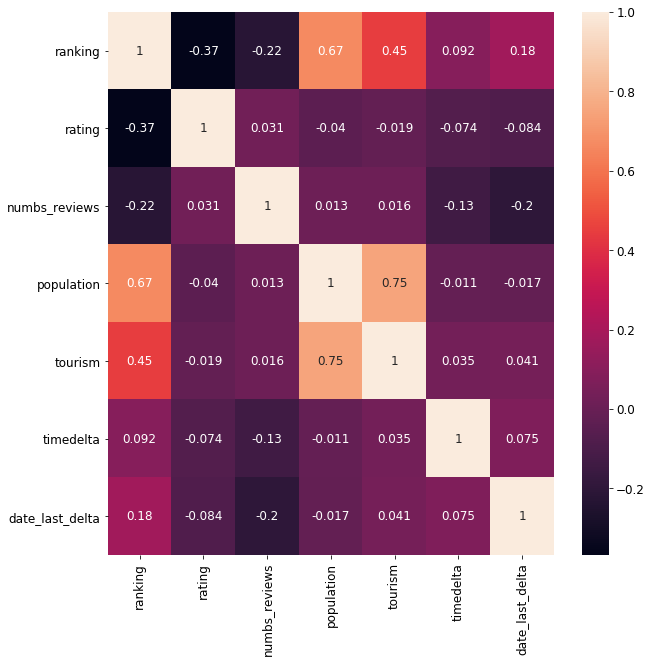

In [44]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(df.corr(), annot=True)

Самая большая корреляция столбцы **rating** относитльно столбца **ranking**. Что объясняется самим значением столбцы **ranking** - место в рейтинге города. 

# FEATURE ENGEENERING 

Создадим новые признаки из текущих данных.  
Признаки, которые уже добавлены: 
- Население  
- количество туристов в год  
- время последнего отзыва  
- время между отзывами  
  
Признаки, которые создаем дополнительно
- список слов (существительных и прилагательных) из отзывов. Выберем самые популярные
- native(1/0) - является ли данная кухня национальной (испанская для Мадрида, Барселона; французская - для Парижа и т.д.)
- плотность населения/турпотока на один ресторан
- кодирование признаков (города, слова    *прим. get_dummies*)

### Анализ отзывов, выбор слов

Создаем список стилей кухни, для того, чтобы убрать повторы в списках слов.

In [45]:
cuisines = list(df['cuisine_style'].str.split(", ").explode().unique())
df.words = df.words.apply(lambda x: str(x)).replace('set()', np.nan)
df_test.words = df_test.words.apply(lambda x: str(x)).replace('set()', np.nan)

Запускаем функцию разделения слов (*или читаем разделенные списки из файла. Работа функции занимает продолжительное время - прим.* )  
Выберем 5 слов, которые могут наиболее полно охарактеризовать отзыв.  
  
*прим. списки слов создаются при подготовке датафрейма*

In [46]:
# считываем файл с разделенными словами или запускаем код ниже. 
df_nlp = pd.read_csv("data_nlp.csv")[['adjs', 'nouns']]
df_test_nlp = pd.read_csv("df_test_nlp.csv")[['adjs', 'nouns']]

#df[~df.words.isna()] = df[~df.words.isna()].apply(words_select, axis=1)

In [47]:
df = df.join(df_nlp)
df_test = df_test.join(df_test_nlp)

Появилось 2 столбца 'adjs'/ 'nouns'  - для прилагательных и сущствительных. Из прилагательных убираем названия стилей кухни. 

In [48]:
df.sample(2)

,res_id,city,cuisine_style,ranking,rating,price_range,numbs_reviews,reviews,url_ta,id_ta,population,tourism,words,date_last,date_prev,cuisine_extra,timedelta,date_last_delta,adjs,nouns
9451,id_6449,Paris,"french, european, healthy, fast food, soups, v...",6450.0,4.0,$,53.0,"[['Nice little restaurant.', 'Perfect snack st...",/Restaurant_Review-g187147-d6687224-Reviews-Co...,d6687224,9803494,67346921,"{'stop', 'restaurant', 'nice', 'little', 'snac...",2017-06-03,2017-05-25,NaN,9,268,perfect little nice,restaurant snack
5914,id_1874,Paris,"french, vegetarian",1875.0,4.0,$$ - $$$,74.0,"[['Great little spot....', 'Nice brasserie'], ...",/Restaurant_Review-g187147-d10784600-Reviews-L...,d10784600,9803494,67346921,"{'great', 'nice', 'brasserie', 'little', 'spot'}",2017-12-01,2017-09-27,NaN,65,87,little great nice,brasserie spot


### Создание домашней кухни для данной страны/города 

In [50]:
df['native'] = df.city.map(native_cousine)
df = df.apply(native_fill, axis=1)
df_test['native'] = df_test.city.map(native_cousine)
df_test = df_test.apply(native_fill, axis=1)
df.drop('native', axis=1, inplace=True)
df_test.drop('native', axis=1, inplace=True)

### Создание плотности населения и турпотока на один ресторан.

In [51]:
# Считаем максимальное количество ресторанов в городе, но не суммой, а номером места из ranking (т.к. много пропущено)
restorans_max = df.groupby('city')['ranking'].max().to_dict()

In [52]:
df['max_rest']=df['city'].map(restorans_max)
df_test['max_rest']=df_test['city'].map(restorans_max)

In [53]:
df['rests_plotn'] = df['population'] / df['max_rest']
df['tourist_plotn'] = df['tourism'] / df['max_rest']
df_test['rests_plotn'] = df_test['population'] / df_test['max_rest']
df_test['tourist_plotn'] = df_test['tourism'] / df_test['max_rest']
df.drop('max_rest', axis=1, inplace=True)
df_test.drop('max_rest', axis=1, inplace=True)

### Нормализация ranking

В разных городах разное количество ресторанов, и в большом городе может быть 50-100 ресторанов с высоким рейтингом, в маленьком может быть в 10 раз меньше. Поэтому 50е место в разных городах может нести разную оценку. Приведем столбец **ranking** к максимальному значению ~100

In [54]:
restorans_max = df.append(df_test, sort=False).groupby('city')['ranking'].max().to_dict()

df['max_rest']=df['city'].map(restorans_max)
df['ranking'] = (df['ranking'] *100 / df['max_rest']) + 1
df['ranking'] = round(df['ranking'], 1)
df = df.drop(['max_rest'],axis=1)

df_test['max_rest']=df_test['city'].map(restorans_max)
df_test['ranking'] = (df_test['ranking'] *100 / df_test['max_rest']) + 1
df_test['ranking'] = round(df_test['ranking'], 1)
df_test = df_test.drop(['max_rest'],axis=1)

### Объеденим датафреймов df и df_test

In [55]:
df.drop(['cuisine_extra'], axis=1, inplace=True)
df_test.drop(['cuisine_extra'], axis=1, inplace=True)

df['sample'] = 1
df_test['sample'] = 0
df_test['rating'] = 0
data = df.append(df_test, sort=False).reset_index(drop=True)

# DATA Prerocessing - подготовка данных

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   res_id           50000 non-null  object        
 1   city             50000 non-null  object        
 2   cuisine_style    44692 non-null  object        
 3   ranking          50000 non-null  float64       
 4   rating           50000 non-null  float64       
 5   price_range      40706 non-null  object        
 6   numbs_reviews    46800 non-null  float64       
 7   reviews          49998 non-null  object        
 8   url_ta           50000 non-null  object        
 9   id_ta            50000 non-null  object        
 10  population       50000 non-null  int64         
 11  tourism          50000 non-null  int64         
 12  words            41881 non-null  object        
 13  date_last        50000 non-null  datetime64[ns]
 14  date_prev        50000 non-null  datet

В функции ниже происходит подготовка данных для модели.  
* Создание get_dummies для столбца city
* Создание get_dummies для столбцы слов 
* Заполнение пробелов с столбцах средним
* Приведение столбцы price_range к числовому виду

*Примечание. после расчета MAE  - кухни, и слова были убраны из подгтовки*

In [57]:
data_all = DataPrep(data)
#data.cuis_dums()
#data_all.nouns_add()
#data_all.adjs_add()
data_all.city_dums()
data_all.price_fill()
data_all.fill_na()
data_all.drops()
data_all = data_all.data

In [58]:
data_all.sample(3)

,ranking,rating,price_range,numbs_reviews,population,tourism,timedelta,date_last_delta,native_yn,rests_plotn,tourist_plotn,sample,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
res_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_2536_Rome,43.7,4.5,1.0,75.0,2872800,28992098,74,67,1,483.1483,4875.8994,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
id_1292_Edinburgh,74.2,4.0,2.0,73.0,488100,4014000,112,210,0,276.3873,2272.9332,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_3406_Paris,45.8,0.0,0.0,15.0,9803494,67346921,160,590,0,700.9505,4815.3097,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [60]:
train_data = data_all.query('sample == 1').drop(['sample'], axis=1)
test_data = data_all.query('sample == 0').drop(['sample'], axis=1)

In [61]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = train_data.drop(['rating'], axis = 1)
y = train_data['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = RANDOM_SEED)
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
y_pred = np.round(y_pred*2,0)/2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE: 0.17005


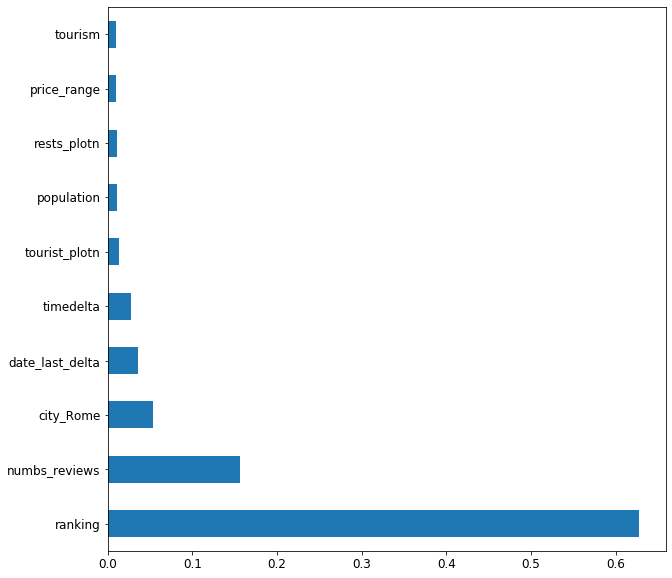

In [63]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
plt.figure(figsize=(10,10))
feat_importances.sort_values(ascending=False).nlargest(10).plot(kind='barh')

# KAGGLE

In [64]:
test_data.sample(5)

,ranking,rating,price_range,numbs_reviews,population,tourism,timedelta,date_last_delta,native_yn,rests_plotn,tourist_plotn,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
res_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_2534_Paris,61.8,0.0,1.0,9.0,9803494,67346921,0,858,0,700.9505,4815.3097,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
id_9645_Budapest,1.5,0.0,2.0,387.0,1749734,10347717,1,50,0,717.6924,4244.3466,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_1700_Amsterdam,48.0,0.0,1.0,11.0,960402,12538000,4,183,0,295.5993,3859.0335,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_1070_Berlin,26.3,0.0,2.0,25.0,3613495,31150090,885,213,0,567.0896,4888.5891,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_15_Paris,93.2,0.0,1.0,39.0,9803494,67346921,50,421,0,700.9505,4815.3097,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [65]:
test_data = test_data.drop(['rating'], axis=1)

In [66]:
sample_submission = pd.read_csv('sample_submission_orig.csv')
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [67]:
predict_submission = regr.predict(test_data)
predict_submission = np.round(predict_submission*2,0)/2
predict_submission

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [68]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.5
8,id_8,4.0
9,id_9,4.5


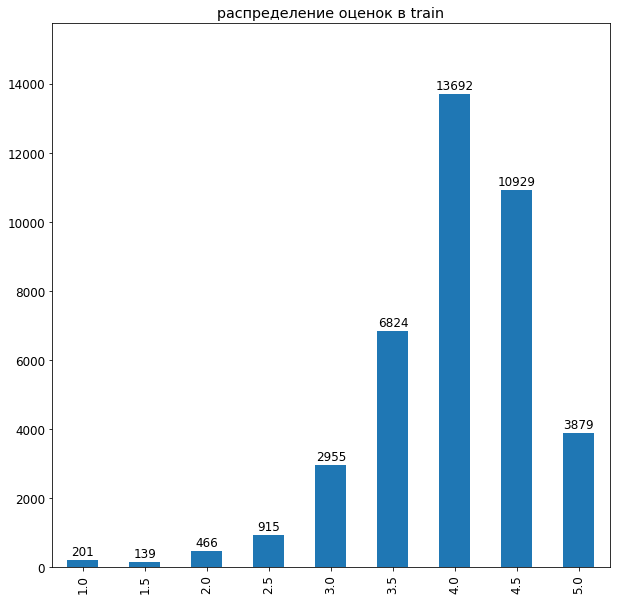

In [69]:
viz_counter_bar(df, 'rating', 'распределение оценок в train', sort_by_index=True)

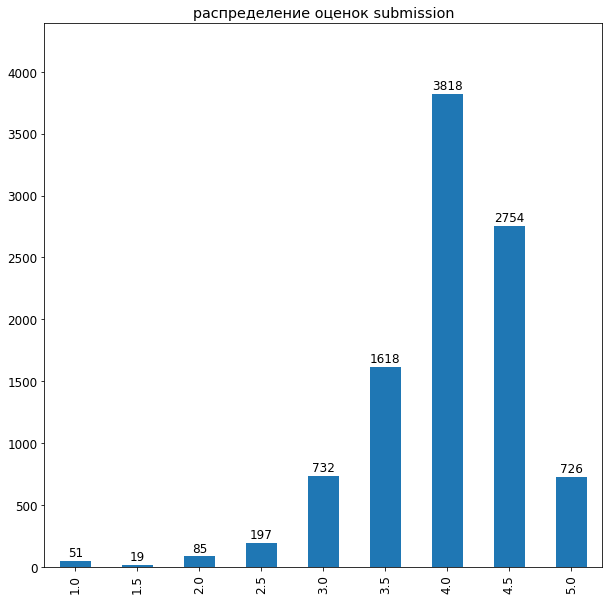

In [70]:
viz_counter_bar(sample_submission, 'Rating', 'распределение оценок submission', sort_by_index=True)

# Заключение.

Наверно можно было сделать лучше. Большое количество признаков - плохо, малое количество признаков тоже плохо.
- Основными признаками оказались, города, ранки, турпоток, население, время отзывов.  
  
Признаки которые оказались лишними, из которых не удалось извлечь пользу.
- Кухни, их разнообразие и оценка
- Анализ слов и оценка (был сделан и удален из совсем плохого MAE на Кагл - 0,67) 

Итог на **KAGGLE** - 0.17490



<img src = "https://raw.githubusercontent.com/Deus99/skillfactory_rds/master/module_3/dicaprio.png">